## 导入必要的安装包

In [1]:
import pandas as pd
import numpy as np
import tushare as ts
import os 
from tqdm import tqdm
import glob
ts.set_token('ce1d8f98f48f0c92fa70a66528612510f350b82ea565bc1abd45b5ac')
debug = False
from datetime import datetime 
pro = ts.pro_api()

## 生成Alpha因子的基础函数

In [2]:
def ts_sum(df, window=10):
    return df.rolling(window).sum()

def sma(df, window=10):
    return df.rolling(window).mean()

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_median(df, window=10):
    return df.rolling(window).median()

def ts_max(df, window=10):
    return df.rolling(window).max()

def delta(df, period=1):
    return df.diff(period)

def delay(df, period=1):
    return df.shift(period)

def rank(df):
    return df.rank(axis=1, pct=True)

def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax) + 1 


## 一系列Alpha因子

In [3]:

class AlphaLib(object):
    def __init__(self, daily_info):
        self.open = daily_info['open']
        self.high = daily_info['high']
        self.low = daily_info['low']
        self.close = daily_info['close']
        self.vwap = daily_info['vwap'] 
        self.volume = daily_info['volume'] 
        self.amount = daily_info['amount']

    def calcu_alpha(self):
        alpha_dict={}
        alpha_dict['alpha01']=((self.close/sma(self.close,10)-1)*self.amount).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha02']=sma(self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha06']=sma((self.close/sma(self.close, 5)-1)*self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha07']=ts_max((self.close/sma(self.close, 15)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha08']=ts_min((self.close/ts_max(self.close, 60)-1)*self.amount,10).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha09']=ts_max((self.close/ts_min(self.close, 60)-1)*self.amount,50).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha10']=ts_max((self.close/ts_min(self.close, 20)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha12']=ts_max((ts_max(self.high,30)/ts_min(self.low, 30)-1)*self.amount,20).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha13']=ts_max(self.high-self.low, 30)/ts_min(self.close+self.open, 30)
        alpha_dict['alpha14']=ts_sum(self.amount*(self.close-self.open), 5)
        alpha_dict['alpha15']=ts_max(self.amount*(self.high-self.low), 15)
        alpha_dict['alpha16']=ts_sum(self.amount*(self.close-self.vwap), 5)
        alpha_dict['alpha17']=ts_min(self.amount*(self.low-self.vwap), 15)
        alpha_dict['alpha18']=ts_min(self.amount*(self.open-self.vwap), 15)
        alpha_dict['alpha19']=ts_min(self.amount*(self.open-self.low), 10)
        alpha_dict['alpha20']=ts_max(self.amount*(self.close-self.low), 10)
        alpha_dict['alpha21']=ts_median(self.amount,15)/ts_sum(self.amount,15)
        alpha_dict['alpha23']=ts_max(self.amount,15)/ts_min(self.amount,10)
        alpha_dict['alpha24']=ts_sum(self.amount.div(self.amount.sum(1),axis=0),5)
        alpha_dict['alpha28']=(ts_max(self.close,5)/delay(self.close,5))*ts_min(self.close,5)/self.close
      
        tmp2=abs((self.close-self.open)/(self.high-self.low+0.01))
        alpha_dict['alpha29']=ts_max(tmp2,6)/ts_min(tmp2,6)
        alpha_dict['alpha30']=tmp2/delay(tmp2,4)

        tmp3=abs((self.low-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha31']=ts_max(tmp3,4)/ts_min(tmp3,4)

        tmp4=abs((self.high-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha32']=ts_max(tmp4,2)/ts_min(tmp4,2)
        
        alpha_dict['alpha_w_005'] = (rank((self.open - (ts_sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
    
        return alpha_dict
        

## 生成训练集

In [4]:
pro = ts.pro_api()
all_stock = pro.stock_basic()
price_PD_total = pd.read_csv('data/price_PD.csv', dtype = {'trade_date': 'str'})
price_PD_total = price_PD_total.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
all_stock = all_stock[['ts_code','name','market','industry']]
price_PD_total = pd.merge(price_PD_total,all_stock,how='left',on='ts_code')
price_PD_total = price_PD_total[['ts_code', 'name','market','industry', 'trade_date', 'open', 'high', 'low',
       'close', 'pre_close','change', 'pct_chg', 'vol', 'amount']]
price_PD_total = price_PD_total[price_PD_total.market.isin(['主板','中小板','创业板'])]
price_PD_total = price_PD_total[~price_PD_total.name.str.contains('ST')].reset_index(drop=True)

In [5]:
##计算开盘涨幅
price_PD_total['open_up'] = price_PD_total.groupby('ts_code').open.shift(1)/price_PD_total.groupby('ts_code').close.shift(0)

In [6]:
#t收盘买 t+1收盘卖
price_PD_total['ret1'] = price_PD_total.groupby('ts_code').close.shift(-1)/price_PD_total.groupby('ts_code').close.shift(0) 
#t+1开盘买 t+2收盘卖
price_PD_total['ret2'] = price_PD_total.groupby('ts_code').close.shift(-2)/price_PD_total.groupby('ts_code').open.shift(-1) 
#t+1开盘买 t+2开盘卖
# price_PD_total['ret3'] = price_PD_total.groupby('ts_code').open.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1) 
# #t+1开盘买 t+3收盘卖
# price_PD_total['ret4'] = price_PD_total.groupby('ts_code').close.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1)
# #t+1开盘买 t+4收盘卖
# price_PD_total['ret5'] = price_PD_total.groupby('ts_code').close.shift(-4)/price_PD_total.groupby('ts_code').open.shift(-1)

price_PD_total['ret'] = price_PD_total['ret2'].copy()



In [7]:

daily_info = {}
daily_info['open'] = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='open')
daily_info['close'] = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='close')
daily_info['high']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='high')
daily_info['low']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='low')
daily_info['volume']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='vol')
daily_info['amount']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='amount')
daily_info['vwap']  = (daily_info['amount']*1000)/(daily_info['volume']*100+1) 


In [8]:
tmp_class = AlphaLib(daily_info)
alpha_dict = tmp_class.calcu_alpha()

In [9]:
data = pd.DataFrame()
for k, v in tqdm(alpha_dict.items()):
    tmp = v.unstack().reset_index().rename(columns={0:k})
    if len(data) == 0:
        data = tmp
    else:
        data = pd.merge(data, tmp, how='left', on=['ts_code', 'trade_date'])

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:20<00:00,  3.20s/it]


In [10]:
data = pd.merge(data, price_PD_total[['trade_date', 'ts_code','name', 'ret1', 'ret2', \
                                    'ret','open_up']], how='left', on=['trade_date', 'ts_code'])

In [11]:
price_PD_total.columns

Index(['ts_code', 'name', 'market', 'industry', 'trade_date', 'open', 'high',
       'low', 'close', 'pre_close', 'change', 'pct_chg', 'vol', 'amount',
       'open_up', 'ret1', 'ret2', 'ret'],
      dtype='object')

In [12]:
# del price_PD_total

In [13]:
data.head()

,ts_code,trade_date,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha29,alpha30,alpha31,alpha32,alpha_w_005,name,ret1,ret2,ret,open_up
0,000001.SZ,20190102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,平安银行,1.009793,1.062092,1.062092,NaN
1,000001.SZ,20190103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.428571,NaN,平安银行,1.050647,1.054113,1.054113,1.011853
2,000001.SZ,20190104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.002469,NaN,平安银行,0.998974,0.981707,0.981707,0.941538
3,000001.SZ,20190107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,155.25,12.888889,NaN,平安银行,0.991786,1.021583,1.021583,0.948665
4,000001.SZ,20190108,NaN,0.002608,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.726923,59.40,2.400000,NaN,平安银行,1.028986,1.036961,1.036961,1.018634


In [14]:
from gplearn import genetic
from gplearn.functions import make_function
from gplearn.genetic import SymbolicTransformer, SymbolicRegressor
from gplearn.fitness import make_fitness
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

In [15]:
fields = ['alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005']


In [16]:
data

,ts_code,trade_date,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha29,alpha30,alpha31,alpha32,alpha_w_005,name,ret1,ret2,ret,open_up
0,000001.SZ,20190102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,平安银行,1.009793,1.062092,1.062092,NaN
1,000001.SZ,20190103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.428571,NaN,平安银行,1.050647,1.054113,1.054113,1.011853
2,000001.SZ,20190104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.002469,NaN,平安银行,0.998974,0.981707,0.981707,0.941538
3,000001.SZ,20190107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,155.250000,12.888889,NaN,平安银行,0.991786,1.021583,1.021583,0.948665
4,000001.SZ,20190108,NaN,0.002608,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.726923,59.400000,2.400000,NaN,平安银行,1.028986,1.036961,1.036961,1.018634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6513595,605599.SH,20250122,5.334277e-07,0.000029,4.240551e-07,2.418639e-06,-0.000006,0.000031,0.000010,0.000022,...,5.062500,1.076923,2.401099,1.554348,-0.530309,菜百股份,1.001835,1.010969,1.010969,0.998165
6513596,605599.SH,20250123,3.943528e-07,0.000021,1.997261e-07,2.006077e-07,-0.000005,0.000026,0.000002,0.000018,...,4.153846,2.250000,2.401099,4.878788,-0.567742,菜百股份,1.012821,1.031193,1.031193,0.990842
6513597,605599.SH,20250124,6.292180e-07,0.000022,1.743784e-07,5.847378e-07,-0.000005,0.000029,0.000002,0.000020,...,8.307692,4.307692,4.222222,3.791667,-0.486858,菜百股份,1.016275,0.974706,0.974706,0.989150
6513598,605599.SH,20250127,1.267579e-06,0.000026,3.013898e-07,1.502688e-06,-0.000005,0.000031,0.000003,0.000022,...,4.307692,2.081633,inf,2.437500,-0.619445,菜百股份,0.959964,NaN,NaN,0.969751


In [17]:
train = data.copy()
# train = train[train.trade_date < '20220101']#.dropna()

train['ret_rank'] = train.groupby('trade_date').ret.rank(pct=True)
train = train[~train.ret_rank.isna()].reset_index(drop=True)


In [18]:
X_train = np.nan_to_num(train[fields])
y_train = np.nan_to_num(train['ret_rank'])

## 模型训练

In [19]:
function_set = ['add', 'sub', 'mul', 'div','sqrt', 'log','inv','sin','max','min']
population_size = 1000
generations = 2
random_state= 42
est_gp = SymbolicTransformer(
                            feature_names=fields, 
                            function_set=function_set,
                            generations=generations,
#                             metric=my_metric,
                            population_size=population_size,
                            tournament_size=30, 
                            random_state=random_state,
                            verbose=2, hall_of_fame=100,
                            parsimony_coefficient=0.0001,
                            p_crossover = 0.4,
                            p_subtree_mutation = 0.01,
                            p_hoist_mutation = 0,
                            p_point_mutation = 0.01,
                            p_point_replace = 0.4,
                            n_jobs = 8)
     

est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  3.3min remaining:  9.8min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.4min finished


   0    11.02       0.00680365       19        0.0473828              N/A      3.43m


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.8min remaining:  8.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.9min finished


   1     6.65        0.0302901       19        0.0473828              N/A      0.00s


SymbolicTransformer(feature_names=['alpha01', 'alpha02', 'alpha06', 'alpha07',
                                   'alpha08', 'alpha09', 'alpha10', 'alpha12',
                                   'alpha13', 'alpha14', 'alpha15', 'alpha16',
                                   'alpha17', 'alpha18', 'alpha19', 'alpha20',
                                   'alpha21', 'alpha23', 'alpha24', 'alpha28',
                                   'alpha29', 'alpha30', 'alpha31', 'alpha32',
                                   'alpha_w_005'],
                    function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'inv', 'sin', 'max', 'min'],
                    generations=2, n_jobs=8, p_crossover=0.4,
                    p_hoist_mutation=0, p_point_replace=0.4,
                    parsimony_coefficient=0.0001, random_state=42,
                    tournament_size=30, verbose=2)

In [20]:
best_programs = est_gp._best_programs
best_programs_dict = {}

for p in best_programs:
    factor_name = 'alpha_' + str(best_programs.index(p) + 1)
    best_programs_dict[factor_name] = {'fitness':p.fitness_, 'expression':str(p), 'depth':p.depth_, 'length':p.length_}
     
best_programs_dict = pd.DataFrame(best_programs_dict).T
best_programs_dict = best_programs_dict.sort_values(by='fitness')
best_programs_dict

,fitness,expression,depth,length
alpha_10,0.039633,"add(alpha06, add(log(alpha16), alpha10))",3,6
alpha_7,0.040824,"max(log(sub(alpha18, alpha16)), mul(alpha24, s...",4,10
alpha_9,0.040846,"add(log(alpha_w_005), log(alpha14))",2,5
alpha_8,0.041358,log(alpha14),1,2
alpha_6,0.042106,"sub(sqrt(min(alpha13, alpha24)), max(log(alpha...",3,10
alpha_5,0.042682,"min(mul(min(min(alpha30, alpha02), log(alpha16...",4,16
alpha_4,0.043971,"log(mul(sub(alpha20, alpha07), min(alpha02, al...",3,8
alpha_3,0.045064,sin(sqrt(log(alpha20))),3,4
alpha_2,0.045113,"min(sqrt(alpha13), sin(sqrt(log(alpha20))))",4,7
alpha_1,0.045483,"sub(mul(log(sqrt(alpha12)), max(sub(alpha08, a...",4,19


In [21]:
factors_pred = est_gp.transform(X_train)
pred_data = pd.DataFrame(factors_pred).T.T
pred_data

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0,-12.247189,12.247189,13.222461,13.222461,12.247189
...,...,...,...,...,...,...,...,...,...,...
5720754,-0.218150,0.039778,0.039778,-0.613112,0.0,-9.607987,11.071603,9.976557,8.106957,8.370752
5720755,-0.859286,0.039778,0.039778,-0.738629,0.0,-9.608582,11.013289,9.310504,8.093588,6.515354
5720756,-1.692870,0.095065,0.095065,-1.154126,0.0,-9.268589,11.047144,8.722995,8.088698,7.924732
5720757,-1.630796,0.095065,0.095065,-1.468116,0.0,-9.269363,9.285357,7.290923,6.724833,8.311505


In [22]:
alpha = train.copy()
alpha['factor'] = pred_data[9]
alpha.head()

,ts_code,trade_date,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha31,alpha32,alpha_w_005,name,ret1,ret2,ret,open_up,ret_rank,factor
0,000001.SZ,20190102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,平安银行,1.009793,1.062092,1.062092,NaN,0.926439,0.000000
1,000001.SZ,20190103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.428571,NaN,平安银行,1.050647,1.054113,1.054113,1.011853,0.532308,0.000000
2,000001.SZ,20190104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.002469,NaN,平安银行,0.998974,0.981707,0.981707,0.941538,0.067077,0.000000
3,000001.SZ,20190107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,155.25,12.888889,NaN,平安银行,0.991786,1.021583,1.021583,0.948665,0.863189,0.000000
4,000001.SZ,20190108,NaN,0.002608,NaN,NaN,NaN,NaN,NaN,NaN,...,59.40,2.400000,NaN,平安银行,1.028986,1.036961,1.036961,1.018634,0.934809,12.247189


In [23]:
alpha = pd.merge(alpha,all_stock[['ts_code','industry']],how='left',on='ts_code')

In [24]:
alpha['factor_rank'] = alpha.groupby(['trade_date','industry']).factor.rank(pct=True,method='dense')


In [25]:
def fun(x):
    if x < 0.2: return 1
    elif 0.2 <= x < 0.4: return 2
    elif 0.4 <= x < 0.6: return 3
    elif 0.6 <= x < 0.8: return 4
    elif 0.8 <= x <= 1: return 5
    else: return np.nan
alpha['factor_rank_bin'] = alpha.factor_rank.apply(fun)

In [26]:
alpha.factor_rank_bin.value_counts()

5    1250090
3    1145050
2    1141595
4    1141595
1    1042429
Name: factor_rank_bin, dtype: int64

<AxesSubplot:xlabel='trade_date'>

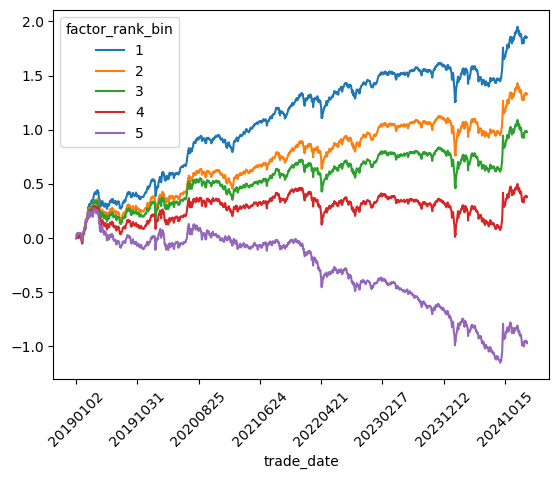

In [27]:
(alpha.groupby(['factor_rank_bin', \
        'trade_date']).ret1.mean()-1).unstack().T.cumsum().plot(rot=45)

<AxesSubplot:xlabel='trade_date'>

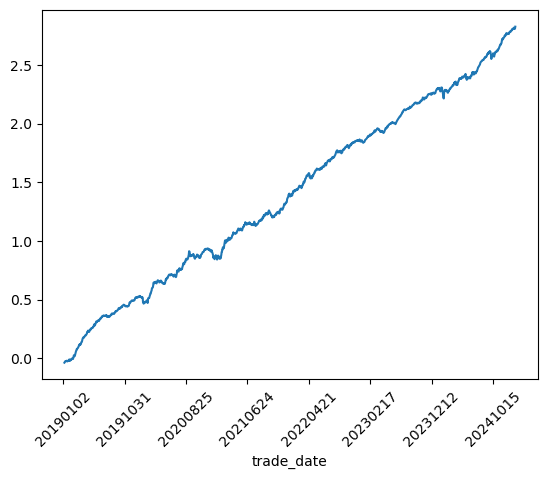

In [29]:
##计算做多做空收益
##做多factor最大的一组，做空factor最小的一组

long_ret = (alpha[(alpha.factor_rank_bin == 5)].groupby('trade_date').ret1.mean()-1).cumsum()
short_ret = (alpha[(alpha.factor_rank_bin == 1)].groupby('trade_date').ret1.mean()-1).cumsum()
(short_ret - long_ret).plot(rot=45)

In [30]:
ret_PD = (alpha.groupby(['factor_rank_bin', 'trade_date']).ret1.mean()-1.00).unstack().T

if ret_PD[1.0].mean()>ret_PD[5.0].mean():
    ret_PD['diff'] = ret_PD[1.0] - ret_PD[5.0]
else:
    ret_PD['diff'] = ret_PD[5.0] - ret_PD[1.0]


In [31]:
def cal_sell_turnover(tmp):
    stock = pd.DataFrame(tmp.groupby('trade_date').apply(lambda x: set(x.ts_code))).rename(columns={0:'stock_list'})
    stock['stock_list_shift1'] = stock.stock_list.shift(1)
    stock = stock.dropna()
    freq = []
    for i in range(len(stock)):
        freq.append(1 - len(stock.iloc[i]['stock_list'] & stock.iloc[i]['stock_list_shift1'])/len(stock.iloc[i]['stock_list']))
    stock['freq'] = freq
    return stock['freq'].mean()

def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end


def max_dd_month(ret_PD):
    ret2_month = ret_PD.reset_index()
    ret2_month['month'] = [str(xx)[:6] for xx in ret2_month['trade_date']]    
    ret2_month = ret2_month.groupby('month')['ret'].sum()
    ret2_month = ret2_month.sort_values()
    return [ret2_month.head(1).values[0],ret2_month.head(1).index[0],\
            (ret2_month>0).sum()/len(ret2_month),ret2_month[ret2_month>=0].mean(),\
            ret2_month[ret2_month<0].mean()]

 

def calc_pfmc(ret_PD):
    performance = []
    for i in [1,2,3,4,5,'diff']:
        returnlist = ret_PD[i]
        ret_year = (returnlist.mean()-0)*252
        ret_sharpe = (returnlist.mean()-0)/returnlist.std()*(252**0.5)
        max_draw, start, end = max_dd(returnlist)
        winratio = (returnlist>0).sum()/len(returnlist)
        std = returnlist.std()
        performance.append([i,ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    return performance

calc_pfmc(ret_PD)

,group_name,return,sharpe,std,winratio,mdd
0,1,0.317948,1.353955,0.014793,0.574338,-0.138373
1,2,0.228102,0.943983,0.015222,0.561439,-0.171476
2,3,0.167887,0.685909,0.015419,0.541752,-0.204288
3,4,0.064578,0.263818,0.015420,0.518669,-0.310293
4,5,-0.166474,-0.672604,0.015591,0.490156,-1.119786
5,diff,0.491516,4.535640,0.006827,0.644263,-0.048531
